In [101]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
from matplotlib.lines import Line2D


np.random.seed(0)

In [102]:
class Neuron_Layer():
    def __init__(self, n_inputs,n_neurons):
        self.weights = 0.1*np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1,n_neurons))
        pass

    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights)+self.biases
        pass
    
    def backward(self,dvalues):
        # Biases are constants so do not have an effect on dweights
        self.dweights = np.dot(self.inputs.T, dvalues) # f(a,b) = a*b => f`a(a,b) = b
        # # f(a,b) = a + b => f`b(a,b) = 1, accumulate gradient from all samples
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

In [103]:
class Activation_ReLU():
    def forward(self,inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
        
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [104]:
class Activation_Softmax():
    def forward(self,inputs):
        exps = np.exp(inputs - np.max(inputs,axis=1,keepdims=True))
        normalised = exps / np.sum(exps,axis=1,keepdims=True)
        self.output = normalised
    
    def backward(self,dvalues): 
        # TODO Reread 216-225
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output,single_dvalues) in enumerate(zip(self.output,dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
                              
            # Calculate sample-wise gradient.
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [105]:
class Optimizer_SGD:
    def __init__(self,learning_rate=1.0, decay=0., momentum=0.):
        self.learning_rate=learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self,layer : Neuron_Layer):
        # Momentum helps to not get stuck in a local minimum
        if self.momentum:
            if not hasattr(layer,"weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        layer.weights += weight_updates
        layer.biases += bias_updates
    
    def post_update_params(self):
        self.iterations += 1

In [106]:
class Loss:
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [107]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self,y_pred,y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred,1e-7,1-1e-7)
        
        if len(y_true.shape)==1: # Labels are class indicies
            correct_confidences = y_pred_clipped[range(samples),y_true]
        elif len(y_true.shape)==2: # One hot encoding
            correct_confidences = np.sum(y_pred_clipped*y_true,axis=1)
        
        loss = -np.log(correct_confidences)
        return loss
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape)==1:
            # If it is sparse, convert to one-hot
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true/dvalues # Calculate gradient
        self.dinputs = self.dinputs/samples # Normalize gradient

In [108]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self,inputs,y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output,y_true)
    
    def backward(self,dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape)==2: # If one hot, turn it into sparse (discrete)
            y_true = np.argmax(y_true,axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -=1
        self.dinputs = self.dinputs / samples 

In [109]:
def load_mnist_images(path):
    with open(path, "rb") as f:
        magic = int.from_bytes(f.read(4), "big")
        num_images = int.from_bytes(f.read(4), "big")
        rows = int.from_bytes(f.read(4), "big")
        cols = int.from_bytes(f.read(4), "big")

        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)

    return images

In [110]:
def load_mnist_labels(path):
    with open(path, "rb") as f:
        magic = int.from_bytes(f.read(4), "big")
        num_labels = int.from_bytes(f.read(4), "big")

        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return labels


In [111]:
images = load_mnist_images("./data/train-images.idx3-ubyte")
labels = load_mnist_labels("./data/train-labels.idx1-ubyte")

res = len(images[0])
print(f"Images are res: {res}*{res}px")
images = images.astype(np.float32) / 255.0
images = images.reshape(60000, 784)



Images are res: 28*28px


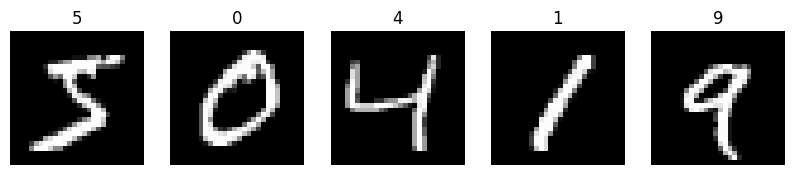

In [112]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

for i, ax in enumerate(axes):
    ax.imshow(images[i].reshape(28, 28), cmap="gray")
    ax.set_title(labels[i])
    ax.axis("off")

plt.show()

In [113]:
layer1 = Neuron_Layer(res*res,8)
activation1 = Activation_ReLU()

layer2 = Neuron_Layer(8,8)
activation2 = Activation_ReLU()

layer3 = Neuron_Layer(8,10)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD(learning_rate=0.65,decay=0.01,momentum=0.5)

if len(labels.shape)==2:
    labels = np.argmax(labels,axis=1)


In [114]:
for epoch in range(251):
    layer1.forward(images)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    loss = loss_activation.forward(layer3.output,labels)
    
    predictions = np.argmax(loss_activation.output,axis=1)
    acc = np.mean(predictions==labels)
    if epoch%10==0:
        print(f"Epoch: {epoch} | Acc: {acc} | Loss: {loss}")
    
    loss_activation.backward(loss_activation.output,labels)
    layer3.backward(loss_activation.dinputs)
    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.update_params(layer3)
    optimizer.post_update_params()
    
    

Epoch: 0 | Acc: 0.1207 | Loss: 2.3058358783870867
Epoch: 10 | Acc: 0.13813333333333333 | Loss: 2.208360834131014
Epoch: 20 | Acc: 0.39891666666666664 | Loss: 1.6527258752505758
Epoch: 30 | Acc: 0.27398333333333336 | Loss: 2.094778397025045
Epoch: 40 | Acc: 0.4729833333333333 | Loss: 1.4332403613334794
Epoch: 50 | Acc: 0.67175 | Loss: 1.0327616592266455
Epoch: 60 | Acc: 0.58315 | Loss: 1.2892876033048732
Epoch: 70 | Acc: 0.6049833333333333 | Loss: 1.1069577361124423
Epoch: 80 | Acc: 0.74485 | Loss: 0.7914071711189292
Epoch: 90 | Acc: 0.7436333333333334 | Loss: 0.7908195140856541
Epoch: 100 | Acc: 0.7163 | Loss: 0.7891978295717279
Epoch: 110 | Acc: 0.7874333333333333 | Loss: 0.6366265238089145
Epoch: 120 | Acc: 0.7577333333333334 | Loss: 0.7485834784151582
Epoch: 130 | Acc: 0.7896 | Loss: 0.658023430441782
Epoch: 140 | Acc: 0.8408166666666667 | Loss: 0.5235306556518068
Epoch: 150 | Acc: 0.8043333333333333 | Loss: 0.6153713758686354
Epoch: 160 | Acc: 0.8565 | Loss: 0.4859706697444121
Epoc

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

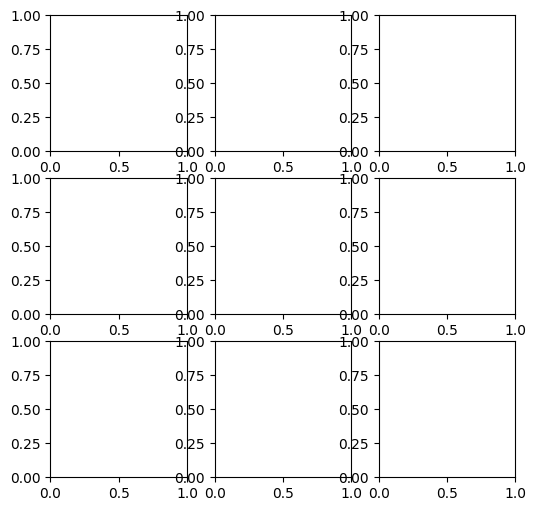

In [ ]:
layer1.forward(images)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)
layer3.forward(activation2.output)
loss = loss_activation.forward(layer3.output,labels)

predictions = np.argmax(loss_activation.output,axis=1)
acc = np.mean(predictions==labels)

fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Real: {labels[i]} | Pred: {predictions[i]}")
    ax.axis("off")

plt.show()